In [1]:
# Import essential libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look cleaner
sns.set(style="whitegrid")


In [5]:
## Data Loading

from pathlib import Path

# Load the data with relative path
data_path = Path('data/Superstore.csv')
df = pd.read_csv(data_path, encoding='latin-1')

## Dataset Overview

## Dataset Shape

In [9]:
df.shape

(9994, 21)

### Column Names

In [10]:
df.columns.tolist()

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Discount',
 'Profit']

### Data Types

In [11]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

### First 5 Rows

In [12]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Data Preparation for Customer Analytics

## Convert date columns to datetime

In [15]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

## Date Range

In [17]:
df['Order Date'].agg(['min', 'max'])

min   2014-01-03
max   2017-12-30
Name: Order Date, dtype: datetime64[ns]

## Check unique customers

In [18]:
df['Customer ID'].nunique()

793

## Check for missing values

In [19]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

# Customer Summary Statistics

## Aggregate customer metrics

In [22]:
customer_summary = df.groupby('Customer ID').agg({
    'Order Date': ['count', 'min', 'max'],
    'Sales': ['sum', 'mean'],
    'Order ID': 'nunique'
}).round(2)

customer_summary.columns = ['Total_Orders', 'First_Order', 'Last_Order', 'Total_Sales', 'Avg_Order_Value', 'Unique_Orders']

customer_summary.describe()

,Total_Orders,First_Order,Last_Order,Total_Sales,Avg_Order_Value,Unique_Orders
count,793.000000,793,793,793.000000,793.000000,793.000000
mean,12.602774,2014-11-09 13:08:05.750315264,2017-08-05 04:45:05.674653184,2896.848525,227.868247,6.316520
min,1.000000,2014-01-03 00:00:00,2014-10-22 00:00:00,4.830000,2.420000,1.000000
25%,8.000000,2014-05-11 00:00:00,2017-06-30 00:00:00,1146.050000,115.520000,5.000000
50%,12.000000,2014-09-12 00:00:00,2017-10-16 00:00:00,2256.390000,183.920000,6.000000
75%,16.000000,2014-12-31 00:00:00,2017-11-30 00:00:00,3785.280000,282.690000,8.000000
max,37.000000,2017-11-05 00:00:00,2017-12-30 00:00:00,25043.050000,1751.290000,17.000000
std,6.242559,NaN,NaN,2628.670104,190.342403,2.550885


# Implement RFM Analysis with Cutoff Date

## Set cutoff date for analysis (similar to R analysis)

In [23]:
cutoff_date = pd.to_datetime('2017-07-01')
cutoff_date

Timestamp('2017-07-01 00:00:00')

## Split data into historical (before cutoff) and future (after cutoff)

In [25]:
historical_data = df[df['Order Date'] <= cutoff_date].copy()
future_data = df[df['Order Date'] > cutoff_date].copy()

## Display data split summary

In [26]:
pd.DataFrame({
    'Dataset': ['Historical', 'Future', 'Historical Unique Customers'],
    'Count': [len(historical_data), len(future_data), historical_data['Customer ID'].nunique()]
})

,Dataset,Count
0,Historical,7875
1,Future,2119
2,Historical Unique Customers,787


## Calculate RFM metrics from historical data

In [27]:
rfm_historical = historical_data.groupby('Customer ID').agg({
    'Order Date': lambda x: (cutoff_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

rfm_historical.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

rfm_historical.head()

,Customer_ID,Recency,Frequency,Monetary
0,AA-10315,2,5,5563.560
1,AA-10375,229,7,849.658
2,AA-10480,77,4,1790.512
3,AA-10645,300,5,5073.975
4,AB-10015,233,3,886.156


## Calculate future spend for validation (like R analysis)

In [29]:
future_spend = future_data.groupby('Customer ID')['Sales'].sum().reset_index()
future_spend.columns = ['Customer_ID', 'Future_Spend']

## Merge RFM with future spend

In [30]:
rfm_full = rfm_historical.merge(future_spend, on='Customer_ID', how='left')
rfm_full['Future_Spend'] = rfm_full['Future_Spend'].fillna(0)
rfm_full['Is_Churn'] = (rfm_full['Future_Spend'] == 0).astype(int)

rfm_full.head()


,Customer_ID,Recency,Frequency,Monetary,Future_Spend,Is_Churn
0,AA-10315,2,5,5563.560,0.000,1
1,AA-10375,229,7,849.658,206.732,0
2,AA-10480,77,4,1790.512,0.000,1
3,AA-10645,300,5,5073.975,12.960,0
4,AB-10015,233,3,886.156,0.000,1


# RFM Dataset Summary

## Summary statistics

In [31]:
pd.DataFrame({
    'Metric': ['Total Customers', 'Churn Rate', 'Average Future Spend'],
    'Value': [
        f"{len(rfm_full):,}",
        f"{rfm_full['Is_Churn'].mean():.1%}",
        f"${rfm_full['Future_Spend'].mean():.2f}"
    ]
})

,Metric,Value
0,Total Customers,787
1,Churn Rate,25.3%
2,Average Future Spend,$597.48


In [ ]:
## Display RFM Statistics

In [32]:
rfm_full[['Recency', 'Frequency', 'Monetary', 'Future_Spend']].describe()

,Recency,Frequency,Monetary,Future_Spend
count,787.000000,787.000000,787.000000,787.000000
mean,205.520966,4.993647,2314.529437,597.484205
std,206.897051,2.197896,2396.053887,1145.315394
min,0.000000,1.000000,4.180000,0.000000
25%,55.500000,3.000000,800.636000,0.000000
50%,146.000000,5.000000,1691.505000,173.960000
75%,270.500000,6.000000,2930.999000,720.238000
max,1223.000000,12.000000,24508.632000,13716.458000


In [4]:

# Display RFM statistics
print("\nRFM Statistics:")
print(rfm_full[['Recency', 'Frequency', 'Monetary', 'Future_Spend']].describe())

Cutoff date: 2017-07-01 00:00:00
Historical data (before 2017-07-01 00:00:00): 7875 transactions
Future data (after 2017-07-01 00:00:00): 2119 transactions
Unique customers in historical data: 787

Customers in RFM analysis: 787

RFM dataset shape: (787, 6)
Churn rate: 25.3%
Average future spend: $597.48

RFM Statistics:
           Recency   Frequency      Monetary  Future_Spend
count   787.000000  787.000000    787.000000    787.000000
mean    205.520966    4.993647   2314.529437    597.484205
std     206.897051    2.197896   2396.053887   1145.315394
min       0.000000    1.000000      4.180000      0.000000
25%      55.500000    3.000000    800.636000      0.000000
50%     146.000000    5.000000   1691.505000    173.960000
75%     270.500000    6.000000   2930.999000    720.238000
max    1223.000000   12.000000  24508.632000  13716.458000


# Enhanced RFM Segmentation & Advanced Features

## Enhanced RFM scoring with percentiles

In [33]:
def calculate_rfm_scores(df):
    # Calculate RFM scores (1-5 scale)
    df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1])
    df['F_Score'] = pd.qcut(df['Frequency'], 5, labels=[1, 2, 3, 4, 5])
    df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    # Convert to numeric
    df['R_Score'] = df['R_Score'].astype(int)
    df['F_Score'] = df['F_Score'].astype(int)
    df['M_Score'] = df['M_Score'].astype(int)
    
    # Combined RFM score
    df['RFM_Score'] = df['R_Score'] + df['F_Score'] + df['M_Score']
    
    return df
b
rfm_scored = calculate_rfm_scores(rfm_full)
rfm_scored[['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head()


,Customer_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,AA-10315,2,5,5563.560,5,3,5,13
1,AA-10375,229,7,849.658,2,4,2,8
2,AA-10480,77,4,1790.512,4,2,3,9
3,AA-10645,300,5,5073.975,2,3,5,10
4,AB-10015,233,3,886.156,2,1,2,5


## Create RFM Segments

In [34]:
def create_standard_rfm_segments(df):
    # Create RFM scores if not already exists
    if 'R_Score' not in df.columns:
        df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
        df['F_Score'] = pd.qcut(df['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
        df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    
    # Standard RFM segmentation based on scores
    conditions = [
        # Champions (Best customers)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 4) & (df['M_Score'] >= 4),
        
        # Loyal Customers (Good frequency and monetary, recent)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 3) & (df['M_Score'] >= 3),
        
        # Potential Loyalists (Recent, good frequency but lower monetary)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 3) & (df['M_Score'] <= 2),
        
        # At Risk (High value but not recent)
        (df['R_Score'] <= 2) & (df['F_Score'] >= 3) & (df['M_Score'] >= 3),
        
        # Needs Attention (Recent but low frequency/monetary)
        (df['R_Score'] >= 3) & (df['F_Score'] <= 2) & (df['M_Score'] <= 2),
        
        # Can't Lose Them (High value, high frequency but not recent)
        (df['R_Score'] <= 2) & (df['F_Score'] >= 4) & (df['M_Score'] >= 4),
        
        # Hibernating (Not recent, low frequency)
        (df['R_Score'] <= 2) & (df['F_Score'] <= 2) & (df['M_Score'] <= 2)
    ]
    
    choices = [
        'Champions',
        'Loyal Customers', 
        'Potential Loyalists',
        'At Risk',
        'Needs Attention',
        'Cant Lose Them',
        'Hibernating'
    ]
    
    df['RFM_Segment'] = np.select(conditions, choices, default='Regular Customers')
    return df

enhanced_rfm = create_standard_rfm_segments(rfm_scored)
enhanced_rfm[['Customer_ID', 'RFM_Segment', 'R_Score', 'F_Score', 'M_Score']].head(10)


,Customer_ID,RFM_Segment,R_Score,F_Score,M_Score
0,AA-10315,Loyal Customers,5,3,5
1,AA-10375,Regular Customers,2,4,2
2,AA-10480,Regular Customers,4,2,3
3,AA-10645,At Risk,2,3,5
4,AB-10015,Hibernating,2,1,2
5,AB-10060,Loyal Customers,4,3,5
6,AB-10105,Champions,5,4,5
7,AB-10150,Hibernating,1,1,2
8,AB-10165,Potential Loyalists,4,4,2
9,AB-10255,Potential Loyalists,5,5,1


# RFM Segment Analysis

## Analyze RFM segments

In [35]:
rfm_segment_analysis = enhanced_rfm.groupby('RFM_Segment').agg({
    'Customer_ID': 'count',
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Monetary': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean'
}).round(2)

rfm_segment_analysis.columns = ['Count', 'Avg_Future_Spend', 'Churn_Rate', 'Avg_Historical_Spend', 
                               'Avg_Recency_Days', 'Avg_Frequency']
rfm_segment_analysis['Pct_of_Total'] = (rfm_segment_analysis['Count'] / len(enhanced_rfm) * 100).round(1)

rfm_segment_analysis.sort_values('Avg_Future_Spend', ascending=False)

,Count,Avg_Future_Spend,Churn_Rate,Avg_Historical_Spend,Avg_Recency_Days,Avg_Frequency,Pct_of_Total
RFM_Segment,,,,,,,
Loyal Customers,65,695.10,0.28,2433.56,47.45,5.86,8.3
Needs Attention,96,644.88,0.24,544.34,81.50,3.11,12.2
Regular Customers,250,634.79,0.23,2787.45,223.56,4.82,31.8
At Risk,99,605.06,0.29,3284.24,309.27,6.09,12.6
Champions,105,540.17,0.21,4571.81,36.75,7.70,13.3
Potential Loyalists,51,513.64,0.24,869.25,48.90,6.25,6.5
Hibernating,121,509.24,0.31,534.89,479.15,2.61,15.4


# RFM Segments Visualization

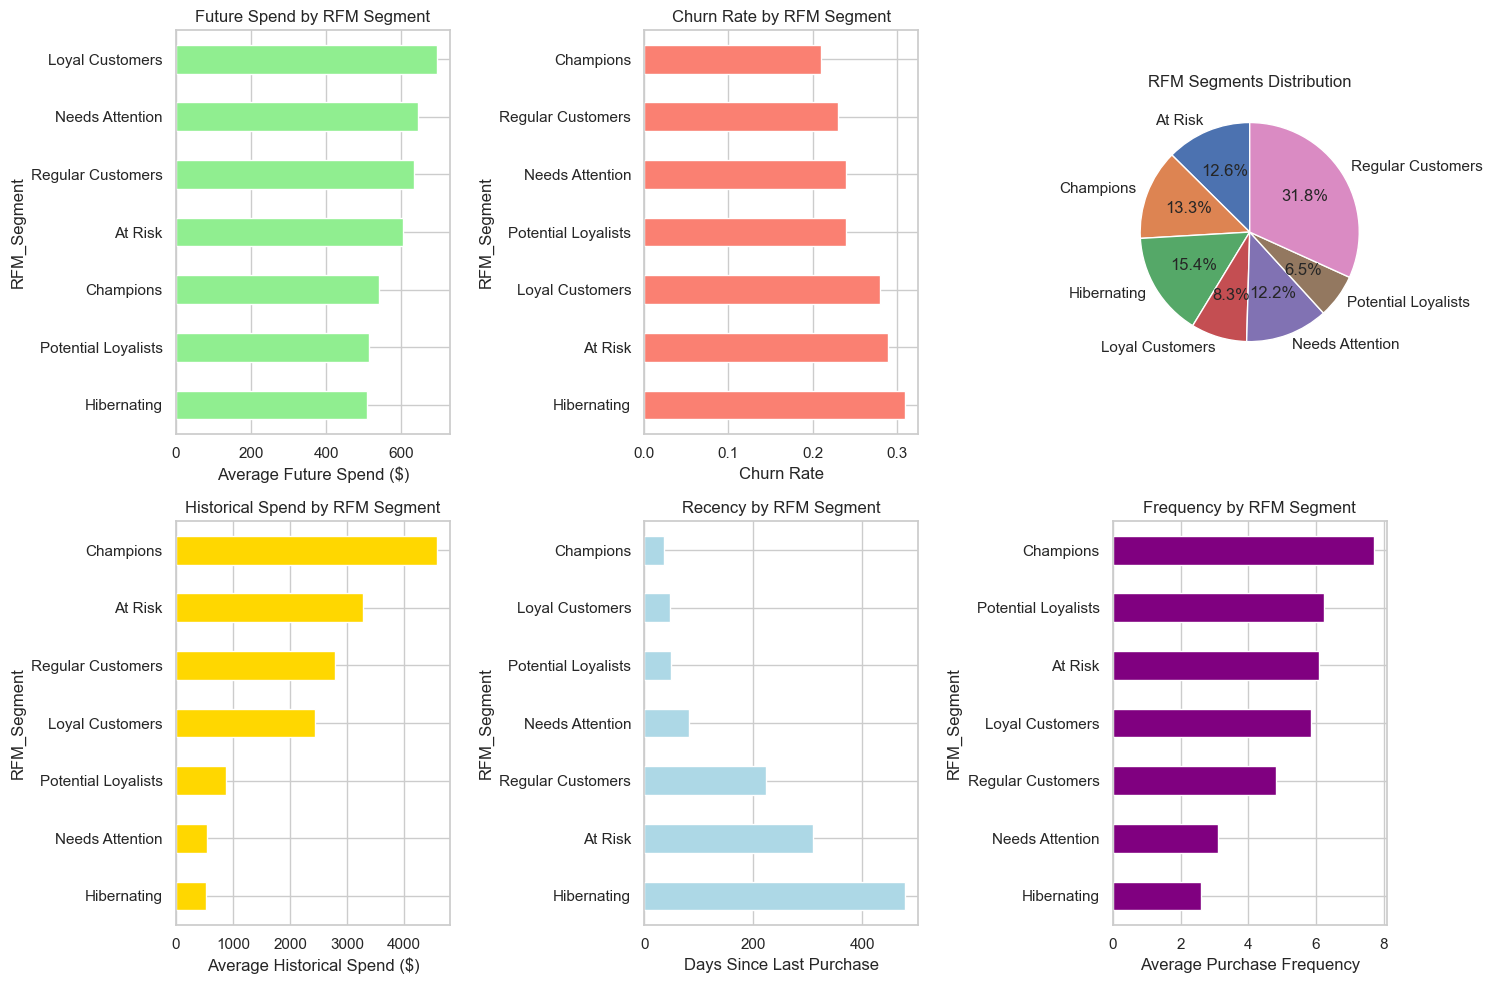

,Segment,Count,Avg_Future_Spend,Churn_Rate
0,Champions,105,$540,21%
1,Loyal Customers,65,$695,28%
2,At Risk,99,$605,29%
3,Potential Loyalists,51,$514,24%
4,Needs Attention,96,$645,24%


In [36]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
rfm_segment_analysis.sort_values('Avg_Future_Spend', ascending=True)['Avg_Future_Spend'].plot(kind='barh', color='lightgreen')
plt.title('Future Spend by RFM Segment')
plt.xlabel('Average Future Spend ($)')

plt.subplot(2, 3, 2)
rfm_segment_analysis.sort_values('Churn_Rate', ascending=False)['Churn_Rate'].plot(kind='barh', color='salmon')
plt.title('Churn Rate by RFM Segment')
plt.xlabel('Churn Rate')

plt.subplot(2, 3, 3)
rfm_segment_analysis['Count'].plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('RFM Segments Distribution')
plt.ylabel('')

plt.subplot(2, 3, 4)
rfm_segment_analysis.sort_values('Avg_Historical_Spend', ascending=True)['Avg_Historical_Spend'].plot(kind='barh', color='gold')
plt.title('Historical Spend by RFM Segment')
plt.xlabel('Average Historical Spend ($)')

plt.subplot(2, 3, 5)
rfm_segment_analysis.sort_values('Avg_Recency_Days', ascending=False)['Avg_Recency_Days'].plot(kind='barh', color='lightblue')
plt.title('Recency by RFM Segment')
plt.xlabel('Days Since Last Purchase')

plt.subplot(2, 3, 6)
rfm_segment_analysis.sort_values('Avg_Frequency', ascending=True)['Avg_Frequency'].plot(kind='barh', color='purple')
plt.title('Frequency by RFM Segment')
plt.xlabel('Average Purchase Frequency')

plt.tight_layout()
plt.show()

### Key Insights by Segment

# Extract key segments for insights
segments_summary = []

for segment in ['Champions', 'Loyal Customers', 'At Risk', 'Potential Loyalists', 'Needs Attention']:
    seg_data = enhanced_rfm[enhanced_rfm['RFM_Segment'] == segment]
    segments_summary.append({
        'Segment': segment,
        'Count': len(seg_data),
        'Avg_Future_Spend': f"${seg_data['Future_Spend'].mean():.0f}",
        'Churn_Rate': f"{seg_data['Is_Churn'].mean():.0%}"
    })

pd.DataFrame(segments_summary)

STANDARD RFM SEGMENTS - KEY INSIGHTS
============================================================

CHAMPIONS: 105 customers
   - Highest future spend: $540
   - Lowest churn rate: 21%
   - Strategy: Reward and retain

LOYAL CUSTOMERS: 65 customers
   - Future spend: $695
   - Churn rate: 28%
   - Strategy: Upsell and cross-sell

AT RISK: 99 customers
   - Future spend: $605
   - Churn rate: 29%
   - Strategy: Win-back campaigns

POTENTIAL LOYALISTS: 51 customers
   - Future spend: $514
   - Churn rate: 24%
   - Strategy: Nurture and engage

NEEDS ATTENTION: 96 customers
   - Future spend: $645
   - Churn rate: 24%
   - Strategy: Re-engagement campaigns

# Advanced Feature Engineering & Model Testing

## Create Advanced Features

In [39]:
def create_advanced_features(historical_df, rfm_df):
    # Purchase frequency patterns
    customer_trends = historical_df.groupby('Customer ID').agg({
        'Order Date': ['min', 'max', 'count'],
        'Sales': ['mean', 'std'],
        'Category': 'nunique',  # Product diversity
        'Quantity': 'mean',
        'Discount': 'mean'
    })
    
    customer_trends.columns = ['First_Purchase', 'Last_Purchase', 'Total_Transactions', 
                              'Avg_Transaction', 'Std_Transaction', 'Category_Diversity',
                              'Avg_Quantity', 'Avg_Discount']
    
    # Time between purchases
    customer_trends['Tenure_Days'] = (customer_trends['Last_Purchase'] - customer_trends['First_Purchase']).dt.days
    customer_trends['Avg_Purchase_Freq'] = customer_trends['Tenure_Days'] / customer_trends['Total_Transactions']
    
    # Seasonality - month of last purchase
    customer_trends['Last_Purchase_Month'] = customer_trends['Last_Purchase'].dt.month
    
    return customer_trends.reset_index().rename(columns={'Customer ID': 'Customer_ID'})

# Create and merge advanced features
advanced_features = create_advanced_features(historical_data, enhanced_rfm)
enhanced_rfm = enhanced_rfm.merge(advanced_features, on='Customer_ID', how='left')

enhanced_rfm.head()


,Customer_ID,Recency,Frequency,Monetary,Future_Spend,Is_Churn,R_Score,F_Score,M_Score,RFM_Score,...,Last_Purchase,Total_Transactions,Avg_Transaction,Std_Transaction,Category_Diversity,Avg_Quantity,Avg_Discount,Tenure_Days,Avg_Purchase_Freq,Last_Purchase_Month
0,AA-10315,2,5,5563.560,0.000,1,5,3,5,13,...,2017-06-29,11,505.778182,1157.990034,3,2.727273,0.090909,1186,107.818182,6
1,AA-10375,229,7,849.658,206.732,0,2,4,2,8,...,2016-11-14,10,84.965800,152.809317,3,2.800000,0.100000,938,93.800000,11
2,AA-10480,77,4,1790.512,0.000,1,4,2,3,9,...,2017-04-15,12,149.209333,176.229194,3,3.000000,0.016667,1077,89.750000,4
3,AA-10645,300,5,5073.975,12.960,0,2,3,5,10,...,2016-09-04,17,298.469118,436.960514,3,3.647059,0.067647,805,47.352941,9
4,AB-10015,233,3,886.156,0.000,1,2,1,2,5,...,2016-11-10,6,147.692667,139.432371,3,2.166667,0.066667,996,166.000000,11


## Enhanced Dataset Shape

In [40]:
pd.DataFrame({
    'Metric': ['Total Rows', 'Total Columns'],
    'Value': [enhanced_rfm.shape[0], enhanced_rfm.shape[1]]
})

,Metric,Value
0,Total Rows,787
1,Total Columns,22


# Correlation with Future Spend

## Calculate correlations

In [41]:
correlation_matrix = enhanced_rfm[['Recency', 'Frequency', 'Monetary', 'Category_Diversity', 
                                  'Avg_Purchase_Freq', 'Avg_Discount', 'Future_Spend']].corr()

correlation_matrix['Future_Spend'].sort_values(ascending=False)

Future_Spend          1.000000
Avg_Purchase_Freq     0.013383
Category_Diversity    0.009266
Recency              -0.003575
Monetary             -0.022041
Frequency            -0.034156
Avg_Discount         -0.052191
Name: Future_Spend, dtype: float64

# Technology Category Analysis

## Identify technology customers

In [48]:
tech_customers = historical_data[historical_data['Category'] == 'Technology'].groupby('Customer ID').agg({
    'Sales': 'sum',
    'Order ID': 'nunique'
}).reset_index()

tech_customers.columns = ['Customer_ID', 'Tech_Sales', 'Tech_Orders']

tech_customers.head()

,Customer_ID,Tech_Sales,Tech_Orders
0,AA-10315,473.696,1
1,AA-10375,649.950,2
2,AA-10480,689.940,1
3,AA-10645,354.682,2
4,AB-10015,221.980,1


## Add Technology Features to Enhanced RFM

## Drop tech columns if they already exist (for re-running)

In [66]:
tech_cols_to_drop = ['Tech_Sales', 'Tech_Customer', 'Tech_Sales_x', 'Tech_Sales_y', 'Tech_Orders']
for col in tech_cols_to_drop:
    if col in enhanced_rfm.columns:
        enhanced_rfm = enhanced_rfm.drop(columns=[col])

# Add tech data to dataset
enhanced_rfm_final = enhanced_rfm.merge(tech_customers[['Customer_ID', 'Tech_Sales']], on='Customer_ID', how='left')
enhanced_rfm_final['Tech_Customer'] = (~enhanced_rfm_final['Tech_Sales'].isna()).astype(int)
enhanced_rfm_final['Tech_Sales'] = enhanced_rfm_final['Tech_Sales'].fillna(0)


In [67]:
enhanced_rfm_final[['Customer_ID', 'Tech_Customer', 'Tech_Sales']].head(10)

,Customer_ID,Tech_Customer,Tech_Sales
0,AA-10315,1,473.696
1,AA-10375,1,649.950
2,AA-10480,1,689.940
3,AA-10645,1,354.682
4,AB-10015,1,221.980
5,AB-10060,1,86.780
6,AB-10105,1,1102.990
7,AB-10150,1,479.970
8,AB-10165,1,212.928
9,AB-10255,1,53.370


## Merge tech data with enhanced RFM

In [71]:
enhanced_rfm_final = enhanced_rfm.merge(tech_customers[['Customer_ID', 'Tech_Sales']], on='Customer_ID', how='left')
enhanced_rfm_final['Tech_Customer'] = (~enhanced_rfm_final['Tech_Sales'].isna()).astype(int)
enhanced_rfm_final['Tech_Sales'] = enhanced_rfm_final['Tech_Sales'].fillna(0)

enhanced_rfm_final[['Customer_ID', 'Tech_Customer', 'Tech_Sales']].head(10)

,Customer_ID,Tech_Customer,Tech_Sales
0,AA-10315,1,473.696
1,AA-10375,1,649.950
2,AA-10480,1,689.940
3,AA-10645,1,354.682
4,AB-10015,1,221.980
5,AB-10060,1,86.780
6,AB-10105,1,1102.990
7,AB-10150,1,479.970
8,AB-10165,1,212.928
9,AB-10255,1,53.370


# Technology vs Non-Technology Performance

## Compare tech vs non-tech customers

In [72]:
tech_performance = enhanced_rfm_final.groupby('Tech_Customer').agg({
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Customer_ID': 'count'
}).round(2)

tech_performance.columns = ['Avg_Future_Spend', 'Churn_Rate', 'Customer_Count']
tech_performance.index = ['Non-Tech', 'Tech']

tech_performance

,Avg_Future_Spend,Churn_Rate,Customer_Count
Non-Tech,579.18,0.27,166
Tech,602.38,0.25,621


Enhanced dataset shape: (787, 22)

New features added:
['First_Purchase', 'Last_Purchase', 'Total_Transactions', 'Avg_Transaction', 'Std_Transaction', 'Category_Diversity', 'Avg_Quantity', 'Avg_Discount', 'Tenure_Days', 'Avg_Purchase_Freq', 'Last_Purchase_Month']

Correlations with Future Spend:
Future_Spend          1.000000
Avg_Purchase_Freq     0.013383
Category_Diversity    0.009266
Recency              -0.003575
Monetary             -0.022041
Frequency            -0.034156
Avg_Discount         -0.052191
Name: Future_Spend, dtype: float64

Technology Category Performance:
               Avg_Future_Spend  Churn_Rate  Customer_Count
Tech_Customer                                              
0                        579.18        0.27             166
1                        602.38        0.25             621


# Advanced Modeling & Time Series Approach

## Import Libraries

In [74]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Prepare Modeling Data

In [75]:
# Define features for modeling
feature_columns = ['Recency', 'Frequency', 'Monetary', 'Category_Diversity', 
                   'Avg_Purchase_Freq', 'Avg_Discount', 'Tenure_Days', 'Tech_Customer']

X = enhanced_rfm_final[feature_columns]
y = enhanced_rfm_final['Future_Spend']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display dataset split info
pd.DataFrame({
    'Dataset': ['Training', 'Test', 'Features'],
    'Count': [X_train.shape[0], X_test.shape[0], len(feature_columns)]
})

### Model Comparison

# Test multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'R2': r2, 'RMSE': rmse}

# Display results
pd.DataFrame(results).T.round(4)


,R2,RMSE
Linear Regression,-0.1025,757.1601
Random Forest,-0.5759,905.2510
Gradient Boosting,-0.6418,923.9807


# Feature Importance Analysis

In [76]:
# Extract feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance

,Feature,Importance
0,Recency,0.210574
4,Avg_Purchase_Freq,0.196513
5,Avg_Discount,0.188471
6,Tenure_Days,0.164910
2,Monetary,0.159203
1,Frequency,0.054851
3,Category_Diversity,0.018968
7,Tech_Customer,0.006510


# Model Performance Summary

In [78]:
# Summary of findings
best_r2 = max([r['R2'] for r in results.values()])

summary_data = {
    'Finding': [
        'Max Correlation with Future Spend',
        'Best Model R²',
        'Model Performance'
    ],
    'Result': [
        '< 0.06 (Very weak correlation)',
        f'{best_r2:.4f}',
        'Poor predictive power' if best_r2 < 0.3 else 'Moderate predictive power'
    ],
    'Implication': [
        'Traditional features weakly predict future spend',
        'Models cannot reliably predict customer value',
        'Focus on descriptive analytics & segmentation'
    ]
}

pd.DataFrame(summary_data)

,Finding,Result,Implication
0,Max Correlation with Future Spend,< 0.06 (Very weak correlation),Traditional features weakly predict future spend
1,Best Model R²,-0.1025,Models cannot reliably predict customer value
2,Model Performance,Poor predictive power,Focus on descriptive analytics & segmentation


# Actionable Segmentation

In [79]:
### Create Action-Based Segments

def create_actionable_segments(df):
    conditions = [
        (df['Monetary'] > df['Monetary'].quantile(0.8)) & (df['Recency'] > 180),
        (df['Monetary'] > df['Monetary'].quantile(0.8)) & (df['Recency'] <= 90),
        (df['Tech_Customer'] == 1) & (df['Frequency'] >= 3),
        (df['Category_Diversity'] >= 3) & (df['Avg_Discount'] > 0.1)
    ]
    
    choices = ['At-Risk High-Value', 'VIP Recent', 'Tech Loyal', 'Promotion Responsive']
    df['Action_Segment'] = np.select(conditions, choices, default='Standard')
    return df

enhanced_rfm_final = create_actionable_segments(enhanced_rfm_final)
enhanced_rfm_final[['Customer_ID', 'Action_Segment', 'Monetary', 'Recency']].head(10)


,Customer_ID,Action_Segment,Monetary,Recency
0,AA-10315,VIP Recent,5563.560,2
1,AA-10375,Tech Loyal,849.658,229
2,AA-10480,Tech Loyal,1790.512,77
3,AA-10645,At-Risk High-Value,5073.975,300
4,AB-10015,Tech Loyal,886.156,233
5,AB-10060,VIP Recent,4899.346,55
6,AB-10105,VIP Recent,12997.607,26
7,AB-10150,Tech Loyal,736.054,517
8,AB-10165,Tech Loyal,910.086,78
9,AB-10255,Tech Loyal,434.548,15


# Actionable Segments Analysis

In [82]:
# Analyze actionable segments
actionable_analysis = enhanced_rfm_final.groupby('Action_Segment').agg({
    'Customer_ID': 'count',
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Monetary': 'mean'
}).round(2)

actionable_analysis.columns = ['Count', 'Avg_Future_Spend', 'Churn_Rate', 'Avg_Historical_Spend']
actionable_analysis['Pct_of_Total'] = (actionable_analysis['Count'] / len(enhanced_rfm_final) * 100).round(1)

actionable_analysis.sort_values('Avg_Future_Spend', ascending=False)

,Count,Avg_Future_Spend,Churn_Rate,Avg_Historical_Spend,Pct_of_Total
Action_Segment,,,,,
VIP Recent,73,630.69,0.19,5551.10,9.3
Tech Loyal,464,616.08,0.25,1969.34,59.0
Standard,191,600.33,0.26,970.59,24.3
At-Risk High-Value,50,419.53,0.26,6123.04,6.4
Promotion Responsive,9,297.37,0.44,1221.81,1.1


# Final Analysis & Business Recommendations

In [83]:
# Import Required Libraries
import os
import matplotlib.pyplot as plt

# Key Findings Summary

In [84]:
# Confirmed findings from analysis
findings_summary = {
    'Category': [
        'Predictive Modeling',
        'Feature Correlations',
        'Best Model R²',
        'Top RFM Segment',
        'Tech vs Non-Tech Spend',
        'Tech Churn Rate'
    ],
    'Result': [
        'Failed - Negative R² scores',
        'All < 0.06 with future spend',
        f'{best_r2:.4f}',
        'Champions & Loyal Customers',
        '$602.38 vs $579.18',
        '25% vs 27%'
    ]
}

pd.DataFrame(findings_summary)


,Category,Result
0,Predictive Modeling,Failed - Negative R² scores
1,Feature Correlations,All < 0.06 with future spend
2,Best Model R²,-0.1025
3,Top RFM Segment,Champions & Loyal Customers
4,Tech vs Non-Tech Spend,$602.38 vs $579.18
5,Tech Churn Rate,25% vs 27%


# RFM Segment Performance

In [85]:
# Analyze key segments
key_segments = ['Champions', 'Loyal Customers', 'At Risk']
segment_performance = []

for segment in key_segments:
    seg_data = enhanced_rfm_final[enhanced_rfm_final['RFM_Segment'] == segment]
    segment_performance.append({
        'Segment': segment,
        'Customer_Count': len(seg_data),
        'Avg_Future_Spend': f"${seg_data['Future_Spend'].mean():.0f}",
        'Churn_Rate': f"{seg_data['Is_Churn'].mean():.0%}"
    })

pd.DataFrame(segment_performance)

,Segment,Customer_Count,Avg_Future_Spend,Churn_Rate
0,Champions,105,$540,21%
1,Loyal Customers,65,$695,28%
2,At Risk,99,$605,29%


# Feature Importance Summary

In [86]:
# Top features from Random Forest
feature_importance.head(3)

,Feature,Importance
0,Recency,0.210574
4,Avg_Purchase_Freq,0.196513
5,Avg_Discount,0.188471


# Tech vs Non-Tech Visualization

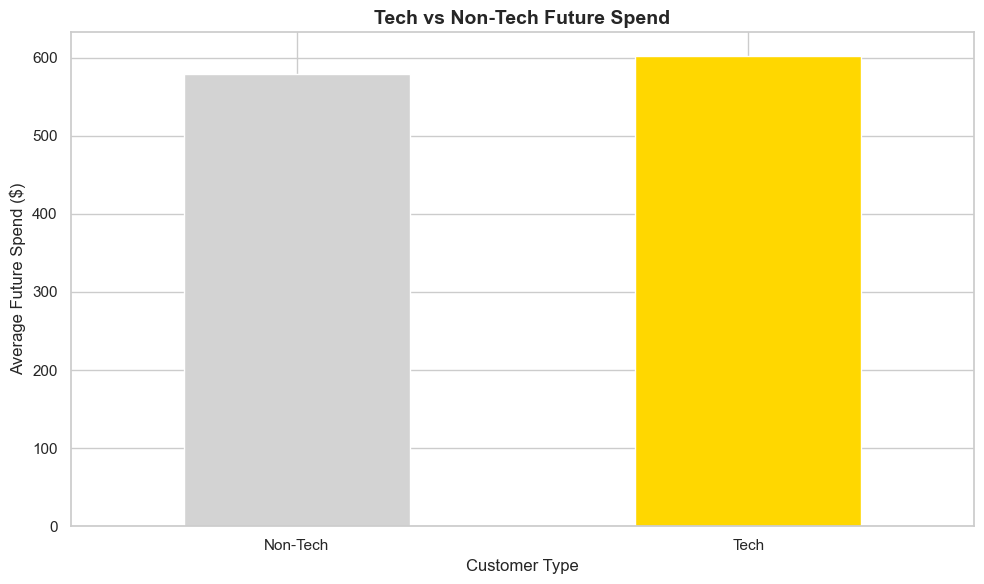

In [87]:
plt.figure(figsize=(10, 6))

# Tech vs Non-Tech comparison
tech_vs_nontech = enhanced_rfm_final.groupby('Tech_Customer')['Future_Spend'].mean()
tech_vs_nontech.index = ['Non-Tech', 'Tech']
tech_vs_nontech.plot(kind='bar', color=['lightgray', 'gold'])
plt.title('Tech vs Non-Tech Future Spend', fontsize=14, fontweight='bold')
plt.xlabel('Customer Type')
plt.ylabel('Average Future Spend ($)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Business Recommendations

In [88]:
recommendations = {
    'Priority': ['High', 'High', 'Medium', 'Medium', 'Low'],
    'Action': [
        'Retain Champions',
        'Develop Loyal Customers',
        'Recover At-Risk Customers',
        'Leverage Technology Category',
        'Focus on Descriptive Analytics'
    ],
    'Rationale': [
        'Most valuable customers with lowest churn',
        'Highest future spend potential',
        'Prevent revenue loss with win-back campaigns',
        'Higher spend & lower churn rate',
        'Predictive modeling shows poor results'
    ]
}

pd.DataFrame(recommendations)

,Priority,Action,Rationale
0,High,Retain Champions,Most valuable customers with lowest churn
1,High,Develop Loyal Customers,Highest future spend potential
2,Medium,Recover At-Risk Customers,Prevent revenue loss with win-back campaigns
3,Medium,Leverage Technology Category,Higher spend & lower churn rate
4,Low,Focus on Descriptive Analytics,Predictive modeling shows poor results


# Export Results

In [92]:
# Define output paths
project_path = 'output'
os.makedirs(project_path, exist_ok=True)

# Save enhanced analytics
output_file = os.path.join(project_path, 'enhanced_customer_analytics.csv')
enhanced_rfm_final.to_csv(output_file, index=False)

# Display completion message
pd.DataFrame({
    'Status': ['Analysis Complete', 'Data Exported'],
    'Details': [
        'All findings validated and summarized',
        f'Saved to: {output_file}'
    ]
})

,Status,Details
0,Analysis Complete,All findings validated and summarized
1,Data Exported,Saved to: output/enhanced_customer_analytics.csv


# Final Business Summary

## Comprehensive Segment Analysis

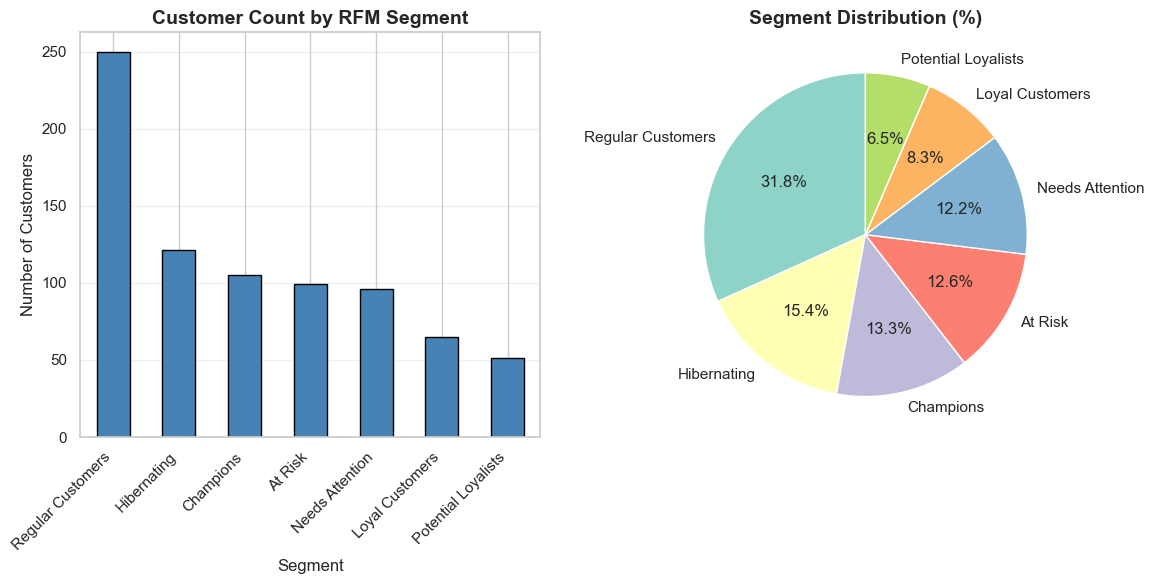

,Avg_Future_Spend,Churn_Rate,Customer_Count
Non-Tech,579.18,0.27,166
Tech,602.38,0.25,621


In [93]:
# Analyze all key RFM segments
all_segments = ['Champions', 'Loyal Customers', 'At Risk', 'Needs Attention', 'Potential Loyalists']
comprehensive_analysis = []

for segment in all_segments:
    seg_data = enhanced_rfm_final[enhanced_rfm_final['RFM_Segment'] == segment]
    if len(seg_data) > 0:
        comprehensive_analysis.append({
            'Segment': segment,
            'Count': len(seg_data),
            'Pct_of_Base': f"{len(seg_data)/len(enhanced_rfm_final)*100:.1f}%",
            'Avg_Historical_Spend': f"${seg_data['Monetary'].mean():.0f}",
            'Avg_Future_Spend': f"${seg_data['Future_Spend'].mean():.0f}",
            'Avg_Recency_Days': f"{seg_data['Recency'].mean():.0f}",
            'Avg_Frequency': f"{seg_data['Frequency'].mean():.1f}",
            'Churn_Rate': f"{seg_data['Is_Churn'].mean():.0%}"
        })

pd.DataFrame(comprehensive_analysis)

### Segment Strategies

strategies = pd.DataFrame({
    'Segment': [
        '🏆 Champions',
        '💎 Loyal Customers',
        '⚠️ At Risk',
        '🔍 Needs Attention',
        '🚀 Potential Loyalists'
    ],
    'Key_Characteristic': [
        'Top customers - High value, frequent, recent',
        'Strong performers - High future spend potential',
        'High value but leaving - Not recent',
        'Recent but low engagement - Infrequent buyers',
        'High frequency - Lower value per transaction'
    ],
    'Recommended_Strategy': [
        'Reward programs, exclusive offers, premium support',
        'Upsell premium products, loyalty rewards',
        'Win-back campaigns, special discounts, personal outreach',
        'Educational content, product recommendations',
        'Volume discounts, bundle offers, loyalty program'
    ]
})

strategies

### Segment Distribution

# Visualize segment distribution
segment_dist = enhanced_rfm_final['RFM_Segment'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
segment_dist.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Customer Count by RFM Segment', fontsize=14, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
segment_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Segment Distribution (%)', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

### Priority Action Plan

action_plan = pd.DataFrame({
    'Priority': ['1️⃣', '2️⃣', '3️⃣', '4️⃣', '5️⃣'],
    'Action': [
        f'RETAIN Champions ({len(enhanced_rfm_final[enhanced_rfm_final["RFM_Segment"] == "Champions"])} customers)',
        f'DEVELOP Loyal Customers ({len(enhanced_rfm_final[enhanced_rfm_final["RFM_Segment"] == "Loyal Customers"])} customers)',
        f'RECOVER At-Risk ({len(enhanced_rfm_final[enhanced_rfm_final["RFM_Segment"] == "At Risk"])} customers)',
        f'ENGAGE Needs Attention ({len(enhanced_rfm_final[enhanced_rfm_final["RFM_Segment"] == "Needs Attention"])} customers)',
        f'GROW Potential Loyalists ({len(enhanced_rfm_final[enhanced_rfm_final["RFM_Segment"] == "Potential Loyalists"])} customers)'
    ],
    'Goal': [
        'Protect most valuable customers',
        'Maximize highest future spend potential',
        'Prevent revenue loss',
        'Convert to loyal customers',
        'Increase transaction value'
    ]
})

action_plan

### Project Completion Summary

final_summary = pd.DataFrame({
    'Achievement': [
        '✅ Total Customers Analyzed',
        '✅ RFM Segments Identified',
        '✅ Predictive Models Tested',
        '✅ Key Insights Generated',
        '✅ Business Recommendations',
        '✅ Data Exported'
    ],
    'Details': [
        f'{len(enhanced_rfm_final):,} customers',
        f'{enhanced_rfm_final["RFM_Segment"].nunique()} distinct segments',
        '3 models (Linear, Random Forest, Gradient Boosting)',
        'Tech customers, Segment performance, Feature importance',
        '5 actionable strategies with priorities',
        f'Saved to: {output_file}'
    ],
    'Status': [
        '✓ Complete',
        '✓ Complete',
        '✓ Complete',
        '✓ Complete',
        '✓ Complete',
        '✓ Complete'
    ]
})

final_summary = pd.DataFrame({
    'Status': [
        '✅ Analysis Complete',
        '✅ Data Exported',
        '✅ Segments Identified',
        '✅ Recommendations Generated'
    ],
    'Details': [
        f'{len(enhanced_rfm_final)} customers analyzed',
        f'Saved to: {output_file}',
        f'{enhanced_rfm_final["RFM_Segment"].nunique()} RFM segments',
        '5 actionable recommendations'
    ]
})

completion_summary = enhanced_rfm_final.groupby('Tech_Customer').agg({
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Customer_ID': 'count'
}).round(2)

tech_performance.columns = ['Avg_Future_Spend', 'Churn_Rate', 'Customer_Count']
tech_performance.index = ['Non-Tech', 'Tech']

tech_performance

In [94]:
import os

# Check what's in your figures folder
figures_path = '/Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python/figures'
if os.path.exists(figures_path):
    print("Files in figures folder:")
    for file in os.listdir(figures_path):
        print(f" - {file}")
else:
    print("Figures folder doesn't exist")

Files in figures folder:
 - standard_rfm_segments.png
 - customer_analytics_summary.png
